In [1]:
# ==============================================================================
# ABSCHNITT 1: SETUP UND KONFIGURATION
# ==============================================================================
# Zweck: Importiert alle notwendigen Bibliotheken und konfiguriert das
#        Erscheinungsbild von Plots und Tabellen für das gesamte Skript.
# ==============================================================================

# --- 1.1 Bibliotheken für Datenanalyse und Visualisierung ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- 1.2 Bibliotheken für Machine Learning und Modellierung ---
# Werkzeuge für Datenaufteilung und Modell-Validierung
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
# Werkzeuge für die Datenvorverarbeitung (Pipelines)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Verschiedene Regressionsmodelle
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# Metriken zur Bewertung der Modellleistung
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Werkzeuge zur Modellinterpretation
import shap
from scipy.stats import randint

# --- 1.3 Globale Konfigurationen für die Anzeige ---
# Pandas-Tabellen kompakter darstellen (weniger Spalten nebeneinander)
pd.set_option('display.max_columns', 15)

# Seaborn/Matplotlib-Plots für bessere Lesbarkeit anpassen
sns.set(style='whitegrid', palette='muted', font_scale=0.9)
plt.rcParams['figure.dpi'] = 80  # Geringere DPI für kompaktere Plots
plt.rcParams['figure.figsize'] = (8, 5)  # Standard-Größe für Plots

print("✅ Abschnitt 1: Setup und Konfiguration abgeschlossen.")


✅ Abschnitt 1: Setup und Konfiguration abgeschlossen.


✅ Datensatz mit 268850 Zeilen und 49 Spalten geladen.
✅ Auf 10406 Einträge für Berlin gefiltert.

📈 --- Start der explorativen Datenanalyse ---


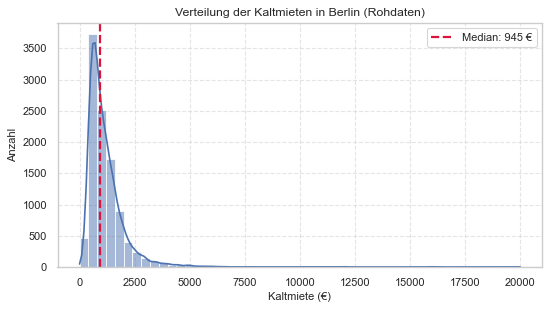

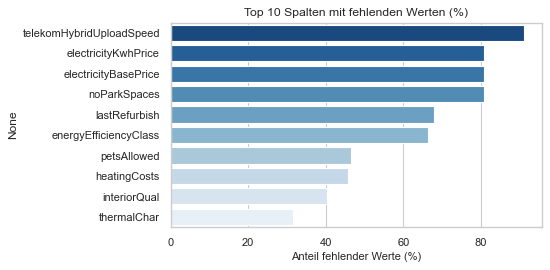

✅ Abschnitt 2: Daten laden und EDA abgeschlossen.


In [2]:
# ==============================================================================
# ABSCHNITT 2: DATEN LADEN UND EXPLORATIVE ANALYSE (EDA)
# ==============================================================================
# Zweck: Lädt den Rohdatensatz, filtert ihn auf Berlin und führt eine erste
#        visuelle Untersuchung durch, um die Daten zu verstehen.
# ==============================================================================

# --- 2.1 Daten aus CSV-Datei laden ---
try:
    df_raw = pd.read_csv('data/immo_data.csv')
    print(f"✅ Datensatz mit {df_raw.shape[0]} Zeilen und {df_raw.shape[1]} Spalten geladen.")
except FileNotFoundError:
    print("❌ Fehler: 'immo_data.csv' nicht gefunden. Stelle sicher, dass die Datei im Ordner 'data/' liegt.")
    exit() # Beendet das Skript, wenn die Datei nicht gefunden wird

# --- 2.2 Datensatz auf Berlin filtern ---
berlin_df = df_raw[(df_raw['regio2'] == 'Berlin') | (df_raw['regio3'] == 'Berlin')].copy()
if berlin_df.empty:
    print("⚠️ Keine Daten für Berlin gefunden. Das Skript wird beendet.")
    exit()
else:
    print(f"✅ Auf {len(berlin_df)} Einträge für Berlin gefiltert.")

# --- 2.3 Explorative Datenanalyse (EDA) ---
print("\n📈 --- Start der explorativen Datenanalyse ---")

def plot_rent_distribution(df):
    """Zeichnet ein Histogramm der Kaltmieten-Verteilung."""
    plt.figure(figsize=(7, 4))
    sns.histplot(df['baseRent'], bins=50, kde=True, color="#4C72B0")
    plt.title('Verteilung der Kaltmieten in Berlin (Rohdaten)', fontsize=11)
    plt.xlabel('Kaltmiete (€)', fontsize=10)
    plt.ylabel('Anzahl', fontsize=10)
    plt.axvline(df['baseRent'].median(), color='crimson', ls='--', lw=2, label=f"Median: {df['baseRent'].median():.0f} €")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

plot_rent_distribution(berlin_df)

def plot_missing_values(df):
    """Zeichnet ein Balkendiagramm der Top 10 fehlenden Werte."""
    missing = df.isnull().mean().sort_values(ascending=False).head(10)
    if not missing.empty:
        plt.figure(figsize=(7, 3.5))
        sns.barplot(x=missing.values * 100, y=missing.index, hue=missing.index, palette="Blues_r", legend=False)
        plt.title("Top 10 Spalten mit fehlenden Werten (%)", fontsize=11)
        plt.xlabel("Anteil fehlender Werte (%)", fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        print("✅ Keine fehlenden Werte in den Top 10 Spalten.")

plot_missing_values(berlin_df)

print("✅ Abschnitt 2: Daten laden und EDA abgeschlossen.")


In [3]:
# ==============================================================================
# ABSCHNITT 3: FEATURE ENGINEERING UND DATENBEREINIGUNG
# ==============================================================================
# Zweck: Umwandlung der Rohdaten in ein sauberes, für das Modellieren
#        geeignetes Format durch Erstellen und Bereinigen von Features.
# ==============================================================================

print("\n🛠️ --- Start Feature Engineering & Datenbereinigung ---")

def engineer_features(df):
    """Wendet Feature Engineering und Bereinigung auf den DataFrame an."""
    df_engineered = df.copy()

    # --- 3.1 Feature Erstellung ---
    # Alter der Immobilie berechnen
    if 'yearConstructed' in df_engineered.columns:
        df_engineered['age'] = 2025 - df_engineered['yearConstructed']
        df_engineered.drop(columns=['yearConstructed'], inplace=True)

    # --- 3.2 Spaltenauswahl und -umbenennung ---
    # Auswahl relevanter Spalten zur Vermeidung von "Ballast"
    relevant_cols = {
        'livingSpace': 'livingSpace',
        'balcony': 'balcony',
        'hasKitchen': 'hasKitchen',
        'condition': 'condition',
        'interiorQual': 'interiorQual',
        'lift': 'lift',
        'age': 'age',
        'baseRent': 'baseRent' # Zielvariable
    }
    # Behalte nur Spalten, die auch wirklich existieren
    existing_cols = {k: v for k, v in relevant_cols.items() if k in df_engineered.columns}
    df_clean = df_engineered[list(existing_cols.keys())].rename(columns=existing_cols)

    # --- 3.3 Ausreißer-Behandlung (auf die Zielvariable) ---
    # Entfernt extreme Mietpreise, die das Modell verzerren könnten
    q_low = df_clean['baseRent'].quantile(0.01)
    q_high = df_clean['baseRent'].quantile(0.99)
    df_clean = df_clean[(df_clean['baseRent'] >= q_low) & (df_clean['baseRent'] <= q_high)]

    # --- 3.4 Log-Transformation der Zielvariable ---
    # Normalisiert die Verteilung der Mieten, was die Modellleistung verbessert
    df_clean['baseRent'] = np.log1p(df_clean['baseRent'])

    # Entfernen von Zeilen, bei denen nach der Bereinigung die Zielvariable fehlt
    df_clean.dropna(subset=['baseRent'], inplace=True)

    print(f"✅ Feature Engineering abgeschlossen. Datensatz hat {df_clean.shape[0]} Zeilen.")
    return df_clean

# Anwenden der Funktion auf den Berlin-Datensatz
df_model = engineer_features(berlin_df)

print("✅ Abschnitt 3: Feature Engineering abgeschlossen.")



🛠️ --- Start Feature Engineering & Datenbereinigung ---
✅ Feature Engineering abgeschlossen. Datensatz hat 10198 Zeilen.
✅ Abschnitt 3: Feature Engineering abgeschlossen.


In [4]:
# ==============================================================================
# ABSCHNITT 4: DEFINITION DER VORVERARBEITUNGS-PIPELINE
# ==============================================================================
# Zweck: Kapselung aller Vorverarbeitungsschritte in einer robusten Pipeline,
#        um Data Leakage zu verhindern und den Workflow zu standardisieren.
# ==============================================================================

print("\n⚙️ --- Definition der Vorverarbeitungs-Pipeline ---")

# --- 4.1 Aufteilung der Daten in Features (X) und Zielvariable (y) ---
X = df_model.drop('baseRent', axis=1)
y = df_model['baseRent']

# --- 4.2 Gruppierung der Features nach Typ ---
# GEÄNDERT: Wir fassen numerische und boolesche Features zusammen, da sie
#           ähnlich behandelt werden können (beide sind im Grunde Zahlen).
numeric_features = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Gefundene numerische/boolesche Features: {numeric_features}")
print(f"Gefundene kategoriale Features: {categorical_features}")


# --- 4.3 Erstellung der Transformer für jeden Feature-Typ ---
# Pipeline für numerische und boolesche Features: Füllt fehlende Werte und skaliert sie.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline für kategoriale Features: Füllt fehlende Werte und wendet One-Hot-Encoding an.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# GEÄNDERT: Der separate boolean_transformer wird nicht mehr benötigt und wurde entfernt.

# --- 4.4 Zusammenführen der Transformer mit ColumnTransformer ---
# Wendet die spezifischen Pipelines auf die richtigen Spalten an.
preprocessor = ColumnTransformer(
    transformers=[
        # GEÄNDERT: Nur noch zwei Transformer, einer für numerische/boolesche, einer für kategoriale.
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

print("✅ Abschnitt 4: Vorverarbeitungs-Pipeline definiert.")



⚙️ --- Definition der Vorverarbeitungs-Pipeline ---
Gefundene numerische/boolesche Features: ['livingSpace', 'balcony', 'hasKitchen', 'lift', 'age']
Gefundene kategoriale Features: ['condition', 'interiorQual']
✅ Abschnitt 4: Vorverarbeitungs-Pipeline definiert.


In [5]:
# ==============================================================================
# ABSCHNITT 5: MODELLTRAINING, TUNING UND EVALUIERUNG
# ==============================================================================
# Zweck: Training, Optimierung und Bewertung des finalen Vorhersagemodells
#        unter Verwendung der zuvor definierten Pipeline.
# ==============================================================================

# --- 5.1 Aufteilung in Trainings- und Test-Set ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\n📚 Daten aufgeteilt: {len(X_train)} Trainings-, {len(X_test)} Test-Einträge.")

# --- 5.2 Erstellung der vollständigen Modell-Pipeline ---
# Wir kombinieren den Preprocessor mit einem Regressionsmodell (hier XGBoost).
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

# --- 5.3 Hyperparameter-Tuning mit RandomizedSearchCV ---
# Definition des Suchraums für die Parameter des Regressors.
# Wichtig: Die Namen müssen mit 'regressor__' beginnen, dem Namen des Schritts in der Pipeline.
param_dist = {
    'regressor__n_estimators': randint(100, 600),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.7, 0.8, 0.9, 1.0],
    'regressor__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Initialisierung und Durchführung der Suche
random_search = RandomizedSearchCV(
    final_pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    verbose=1,
    n_jobs=-1
)

print("\n⚙️ --- Starte Hyperparameter-Tuning... ---")
random_search.fit(X_train, y_train)

# Das beste gefundene Modell (bereits trainiert)
best_model_pipeline = random_search.best_estimator_
print("\n✅ Besten Parameter gefunden:", random_search.best_params_)

# --- 5.4 Evaluierung des finalen Modells auf dem Test-Set ---
# Vorhersagen auf dem ungesehenen Test-Set machen
y_pred_log = best_model_pipeline.predict(X_test)

# Rücktransformation der log-Werte in Euro für eine verständliche Interpretation
y_pred_original = np.expm1(y_pred_log)
y_test_original = np.expm1(y_test)

# Berechnung der finalen Metriken
mae_final = mean_absolute_error(y_test_original, y_pred_original)
rmse_final = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_final = r2_score(y_test_original, y_pred_original)

print(f"\n🎯 Leistung des finalen, getunten Modells auf Testdaten:")
print(f"   -> MAE (Durchschnittlicher Fehler): {mae_final:.2f} €")
print(f"   -> RMSE (Wurzel des mittl. quadr. Fehlers): {rmse_final:.2f} €")
print(f"   -> R² (Bestimmtheitsmaß): {r2_final:.2f}")

print("✅ Abschnitt 5: Modelltraining und Evaluierung abgeschlossen.")



📚 Daten aufgeteilt: 8158 Trainings-, 2040 Test-Einträge.

⚙️ --- Starte Hyperparameter-Tuning... ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

✅ Besten Parameter gefunden: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 8, 'regressor__n_estimators': 540, 'regressor__subsample': 0.7}

🎯 Leistung des finalen, getunten Modells auf Testdaten:
   -> MAE (Durchschnittlicher Fehler): 184.30 €
   -> RMSE (Wurzel des mittl. quadr. Fehlers): 273.36 €
   -> R² (Bestimmtheitsmaß): 0.83
✅ Abschnitt 5: Modelltraining und Evaluierung abgeschlossen.



🔬 --- Start der finalen Modellanalyse ---


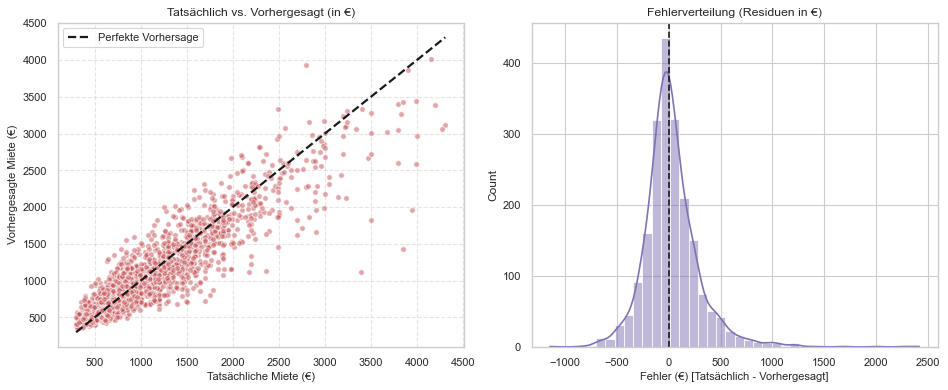


🧠 --- Berechnung der SHAP Feature Importance ---
SHAP Summary Plot (zeigt die wichtigsten Einflussfaktoren auf die Miete):


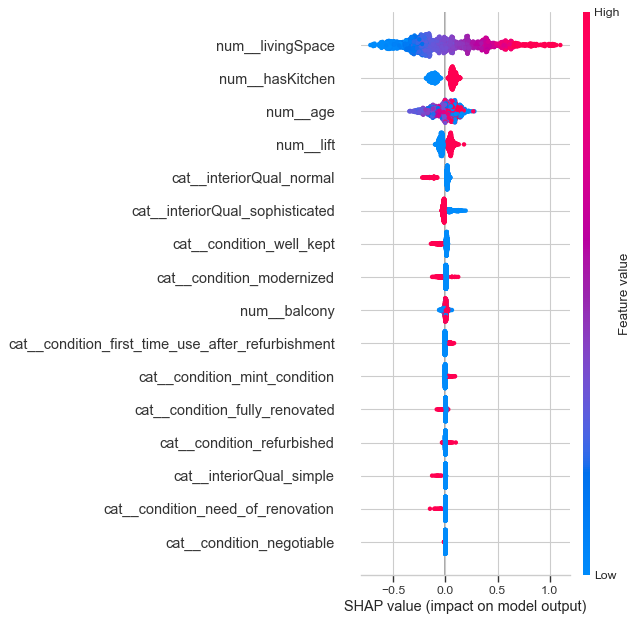


🎉 --- Analyse abgeschlossen --- 🎉


In [6]:
# ==============================================================================
# ABSCHNITT 6: ANALYSE UND INTERPRETATION DES FINALEN MODELLS
# ==============================================================================
# Zweck: Untersuchung der Modellvorhersagen und Interpretation der wichtigsten
#        Einflussfaktoren auf den Mietpreis mit SHAP.
# ==============================================================================

print("\n🔬 --- Start der finalen Modellanalyse ---")

# --- 6.1 Visuelle Fehleranalyse (Residuenplot) ---
def plot_error_analysis(y_true, y_pred):
    """Zeichnet einen Scatterplot und ein Histogramm der Fehler."""
    errors = y_true - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Scatterplot: Tatsächlich vs. Vorhergesagt
    axes[0].scatter(y_true, y_pred, alpha=0.5, edgecolors='w', color='#C44E52', s=25)
    axes[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Perfekte Vorhersage')
    axes[0].set_title('Tatsächlich vs. Vorhergesagt (in €)', fontsize=11)
    axes[0].set_xlabel('Tatsächliche Miete (€)', fontsize=10)
    axes[0].set_ylabel('Vorhergesagte Miete (€)', fontsize=10)
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.5)
    # Histogramm der Fehler
    sns.histplot(errors, bins=40, kde=True, color='#8172B3', ax=axes[1])
    axes[1].axvline(0, color='k', linestyle='--')
    axes[1].set_title('Fehlerverteilung (Residuen in €)', fontsize=11)
    axes[1].set_xlabel('Fehler (€) [Tatsächlich - Vorhergesagt]', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_error_analysis(y_test_original, y_pred_original)

# --- 6.2 Feature Importance mit SHAP ---
print("\n🧠 --- Berechnung der SHAP Feature Importance ---")

# Extrahieren des trainierten Regressors und des Preprocessors aus der Pipeline
regressor = best_model_pipeline.named_steps['regressor']
preprocessor_fitted = best_model_pipeline.named_steps['preprocessor']

# Transformieren der Testdaten, um die Feature-Namen zu erhalten
X_test_transformed = preprocessor_fitted.transform(X_test)
# Holen der finalen Feature-Namen nach dem OneHotEncoding
feature_names = preprocessor_fitted.get_feature_names_out()

# Erstellen eines DataFrames mit den transformierten Daten und korrekten Namen
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

# SHAP-Werte berechnen
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_test_transformed_df)

# Der Summary Plot zeigt die wichtigsten Features und ihren Einfluss.
# Rot bedeutet ein hoher Feature-Wert, Blau ein niedriger.
print("SHAP Summary Plot (zeigt die wichtigsten Einflussfaktoren auf die Miete):")
shap.summary_plot(shap_values, X_test_transformed_df, plot_type="dot")

print("\n🎉 --- Analyse abgeschlossen --- 🎉")
